# Wykorzystując rozkład PCA, ICA spróbować wyznaczyć składową oddechową z sygnału EKG.

### Zespół: Krzysztof Wicki, Tomasz Gruzdzis
### Projekt wykonywany na potrzeby przedmiotu "Obliczeniowe podstawy sztucznej inteligencji"


Notatnik prezentuje wykorzystanie metody PCA i KPCA w celu wyznaczenia składowej oddechowej z sygnału EKG, w literaturze nazywanej EDR z ang. "ECG Derived Respiration".

### 1. Import bibliotek

In [1]:
import numpy as np
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt
import scipy.signal as ss
from scipy import interpolate
from sklearn.decomposition import KernelPCA

from data_loader import Loader

### 2. Załadowanie danych

In [226]:
loader = Loader()

In [227]:
ecg_data = loader.load_ECG()
br_data = loader.load_BR()

In [228]:
ecg_data

array([[-8.4960938e-02,  1.4403086e+05],
       [-8.4960938e-02,  1.4403086e+05],
       [-7.9101562e-02,  1.4403086e+05],
       ...,
       [-3.7500000e-01,  1.5151217e+05],
       [-1.5234375e-01,  1.5151219e+05],
       [-9.9609375e-02,  1.5151219e+05]], dtype=float32)

Sygnatury czasowe filmów, wykorzystywane fo pobierania konkretnych sekwencji EKG

In [229]:
loader.available_border_points

,Event,Started,Ended
0,CLIP-DEMO,144407,144517
1,CLIP-1,144536,144636
2,CLIP-4,144704,144804
3,CLIP-3,144821,144921
4,CLIP-2,144943,145043
5,CLIP-8,145111,145212
6,CLIP-7,145229,145329
7,CLIP-6,145344,145444
8,CLIP-5,145459,145559
9,CLIP-9,145740,145841


Pobranie punktów granicznych sygnału EKG

In [231]:
res = loader.get_index_of_border_points(2, ecg_data)
start = res['started']
end = res['ended']

In [232]:
ecg_signal = ecg_data[start:end, 0]

### 3. Zestawienie sygnału EKG i referencyjnego sygnału oddechowego

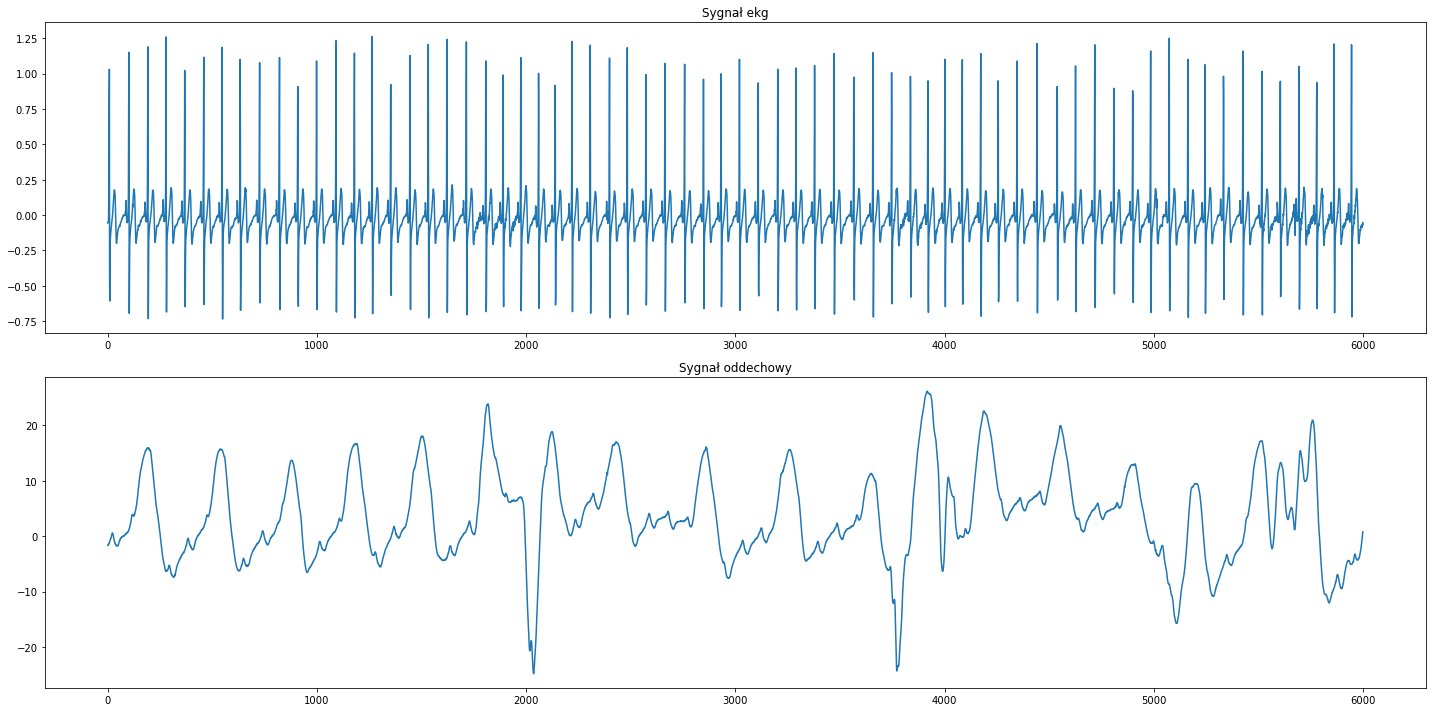

In [233]:
fig, ax = plt.subplots(2, figsize = [20, 10])
ax[0].plot(ecg_signal)
ax[0].set_title('Sygnał ekg')
ax[1].plot(br_data[start:end, 0])
ax[1].set_title('Sygnał oddechowy')

plt.tight_layout()
plt.show()

### 4. Stworzenie macierzy wejściowej, detekcja szczytów R

W pierwszej kolejności wykryte zostają szczyty R

In [234]:
peakR, _ = ss.find_peaks(ecg_signal)
prominences, _, _ = ss.peak_prominences(ecg_signal, peakR)
selected = prominences > 0.5 * (np.min(prominences) + np.max(prominences))
top = peakR[selected]

Oznaczenie szcyztów R na sygnale EKG

No handles with labels found to put in legend.


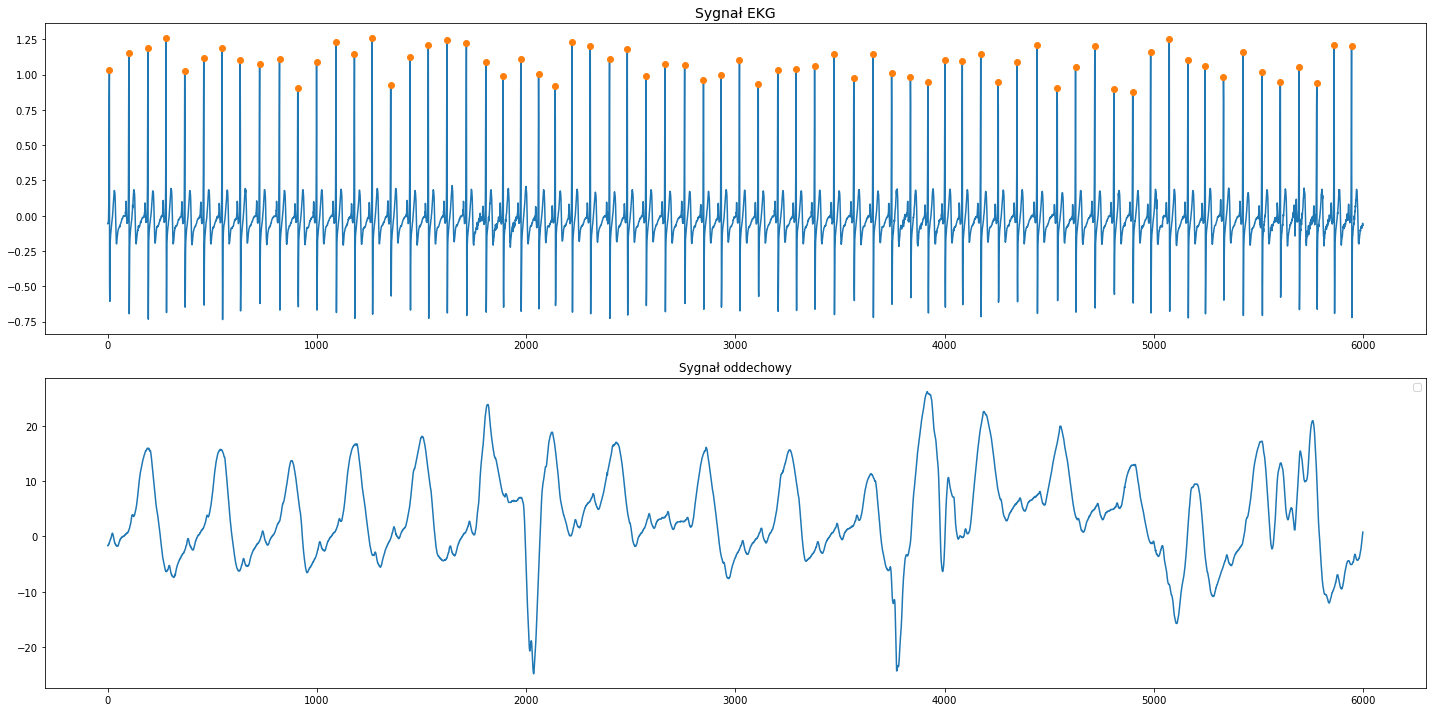

In [235]:
fig, ax = plt.subplots(2, figsize = [20, 10])
ax[0].plot(ecg_signal)
ax[0].plot(top, ecg_signal[top], 'o', label = 'Szczyty R')
ax[0].set_title('Sygnał EKG', fontsize = 14)
ax[1].plot(br_data[start:end, 0])
ax[1].set_title('Sygnał oddechowy')
plt.legend()
plt.tight_layout()
plt.show()

Zdefiniowanie częstotliwości próbkowania i wielkości okna nakładanego na każdy załąmek. Okno obejmuje całe uderzenie.

In [236]:
fs = 100
window = 80

In [237]:
X_matrix = []
for peak in top:
    if peak < window/2:
        continue
    vector = ecg_signal[(peak-int(window/2)):(peak+int(window/2))]
    if vector.size == window:
        X_matrix.append(vector)
X_matrix = np.asarray(X_matrix)

In [238]:
X_matrix.shape

(67, 80)

Wynikowa macierz ma wymiar n na m, gdzie n to ilość szczytów, a m wielkość okna

In [239]:
top

array([   8,  101,  192,  279,  368,  459,  547,  633,  726,  821,  909,
        998, 1091, 1179, 1264, 1353, 1445, 1532, 1621, 1714, 1807, 1890,
       1974, 2059, 2138, 2219, 2306, 2398, 2483, 2572, 2663, 2757, 2847,
       2931, 3019, 3109, 3202, 3290, 3378, 3471, 3566, 3657, 3746, 3836,
       3920, 4001, 4084, 4172, 4255, 4346, 4441, 4537, 4625, 4717, 4809,
       4898, 4984, 5073, 5162, 5244, 5332, 5425, 5516, 5604, 5693, 5778,
       5861, 5944], dtype=int64)

Wynikowy EDR będzie reprezentacją dla każdego szcyztu podanego rozkładowi, także konieczne jest przycięcie sygnałów EKG i BR

In [240]:
ecg_signal_croped = ecg_data[start+top[1]:start+top[-1], 0]
br_signal = br_data[start+top[1]:start+top[-1], 0]

In [241]:
time = np.arange(ecg_signal_croped.size) / fs

### 5. Rozkład PCA

Zastosowano własną implementacje PCA, implementacja z biblioteki Sklearn nie umożliwia dostępu do wektora własnego.

In [242]:
centered_matrix = X_matrix - X_matrix.mean(axis=1)[:, np.newaxis]
cov = np.dot(centered_matrix, centered_matrix.T)
eigvals, eigvecs = np.linalg.eig(cov)

sorted_index = np.argsort(eigvals)[::-1] 
sorted_eigenvalue = eigvals[sorted_index]
sorted_eigenvectors = eigvecs[:,sorted_index]

Interpolacja otrzymanego wektora - własny wektor pierwszy jest w publikacji sygnowany jako ten odpowiedzialny za otrzymanie składowej oddechowej.

In [243]:
ff = ss.resample(sorted_eigenvectors[0], ecg_signal_croped.size)
f = interpolate.interp1d(time, ff)
pca1 = f(time)

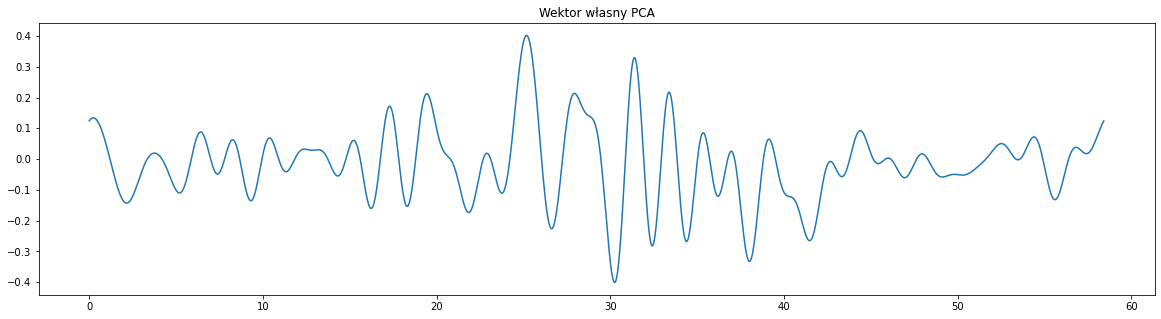

In [244]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)
plt.plot(time, pca1)
plt.title('Wektor własny PCA')
plt.show()

### 6. Zestawienie PCA z KPCA

W celu porównania metod zdecydowano się na KPCA o jądrze rbf

In [245]:
KPCA = KernelPCA(n_components=X_matrix.shape[0], kernel='rbf')
KPCA.fit(X_matrix)
ff = ss.resample(KPCA.alphas_[0], ecg_signal_croped.size)
f = interpolate.interp1d(time, ff)
kpca1 = f(time)

No handles with labels found to put in legend.


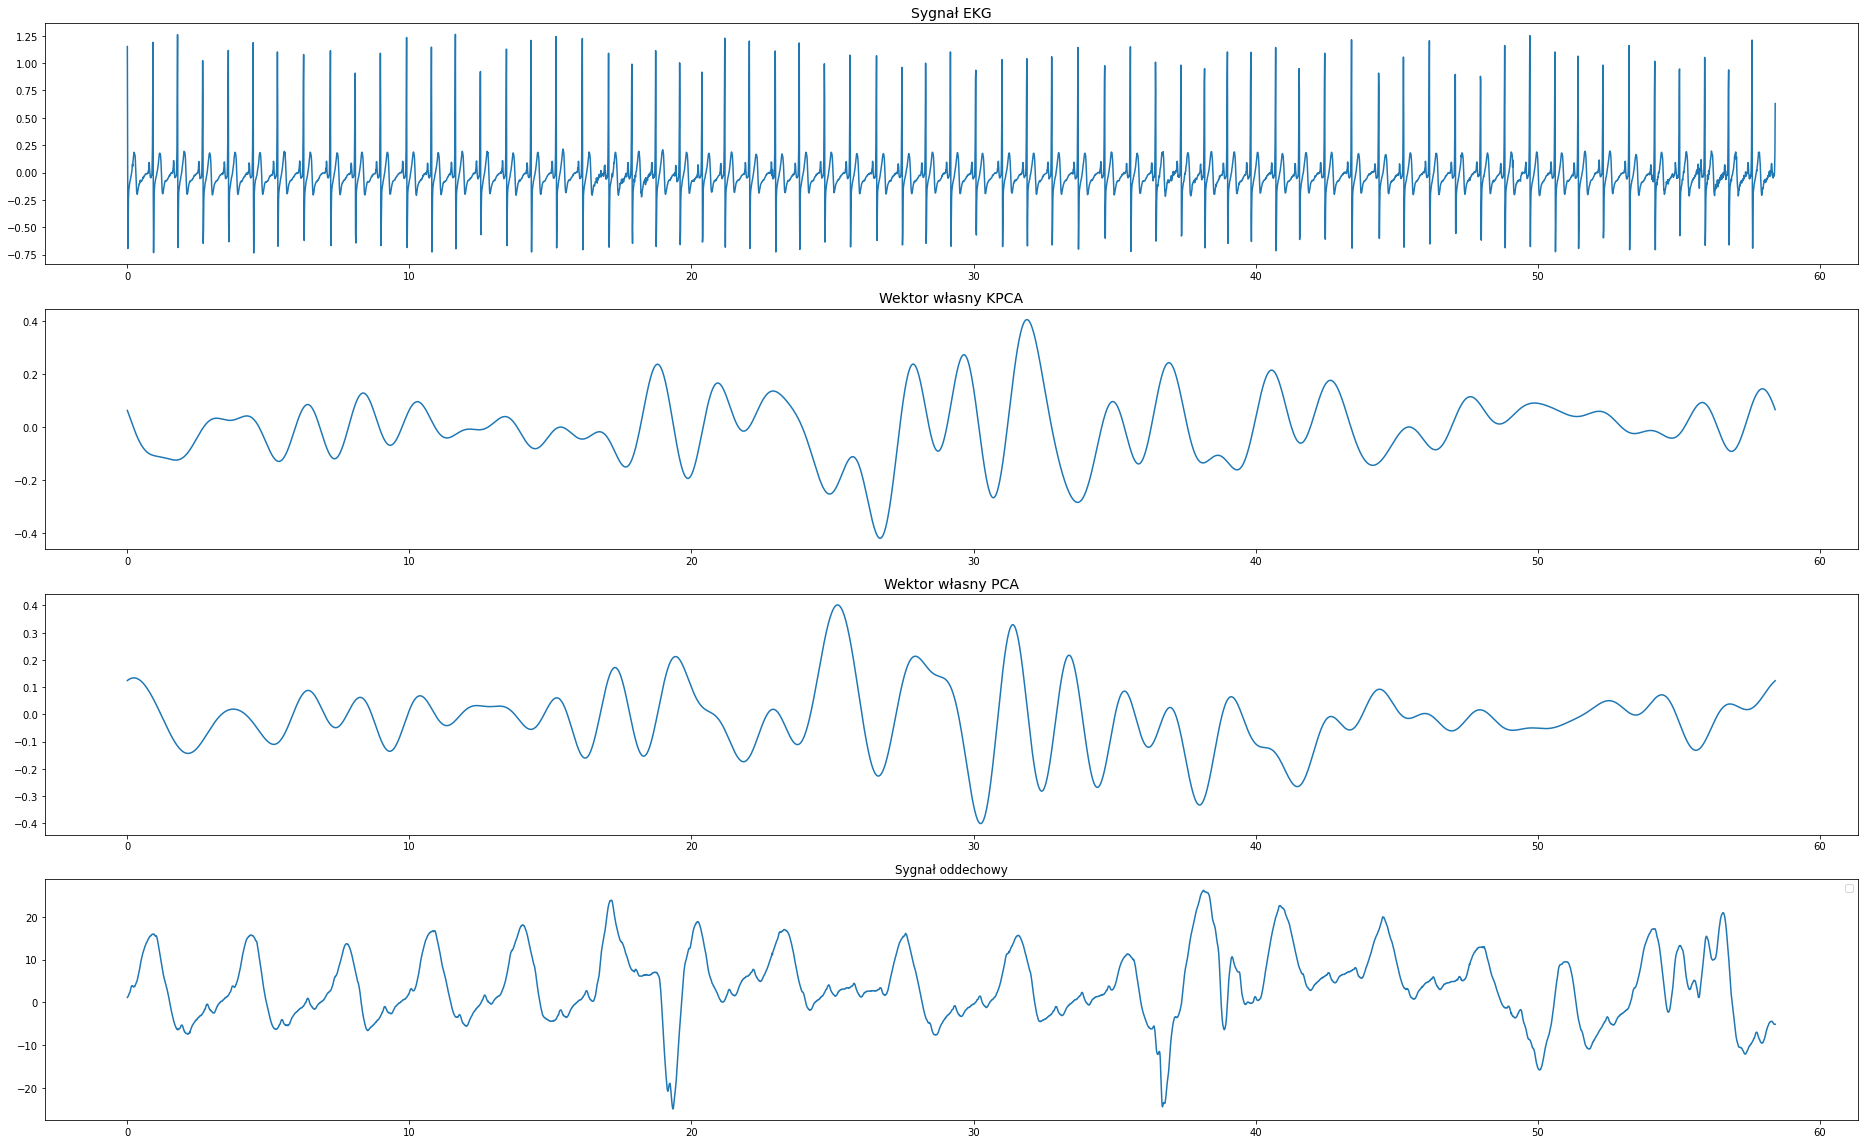

In [247]:
fig, axes = plt.subplots(4, figsize = [26, 16])

axes[0].plot(time, ecg_signal_croped)
axes[0].set_title('Sygnał EKG', fontsize = 14)
axes[1].plot(time, kpca1)
axes[1].set_title('Wektor własny KPCA', fontsize = 14)
axes[2].plot(time, pca1)
axes[2].set_title('Wektor własny PCA', fontsize = 14)
axes[3].plot(time, br_signal)
axes[3].set_title('Sygnał oddechowy')
plt.legend()
plt.tight_layout()
plt.show()

Otrzymane sygnały przypominają ten referencyjny sygnał oddechowy, różnice widoczne są w otrzymanych amplitudach - te wypadają normalnie względem publikacyjnych, częstotliwości sygnałów EDR pokrywają się z sygnałem oddechowym.